In [1]:
import sys
import json
import yaml
import pathlib
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn
import PIL
import math

from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image, to_tensor
from ml_collections import ConfigDict

sys.path.append("..")
from core.dataset import COCODatasetWithID
from core.config import save_config
from core.model import Model
from core.metrics import AccuracyLogger, IndividualScoreLogger

In [2]:
checkpoint = "../output/cv_1/checkpoint_25.tar"
config = "../output/cv_1/config.yaml"

In [3]:
%%capture

with open(config) as f:
        cfg = ConfigDict(yaml.load(f, Loader=yaml.Loader))

if not hasattr(cfg, "num_classes"): # infer number of classes
        with open(cfg.annotations) as f:
            NUM_CLASSES = len(json.load(f)["categories"])
        cfg.num_classes = NUM_CLASSES

# load model
checkpoint = torch.load(checkpoint, map_location="cpu")
model = Model.from_config(cfg)
model.load_state_dict(checkpoint['model_state_dict'])
model.extended_output = True
model.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

In [4]:
encoding = model.positional_encoding.positional_encoding.squeeze()
n = encoding.size(0)
n_per_side = int(math.sqrt(n))

In [5]:
# compute cosine similarity between all pairs of encodings
similarities = np.zeros((encoding.size(0), encoding.size(0)))

for i in range(n):
    for j in range(n):
        similarities[i,j] = torch.nn.functional.cosine_similarity(encoding[i], encoding[j], dim=0)

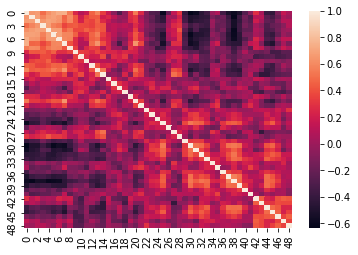

In [6]:
sns.heatmap(similarities)

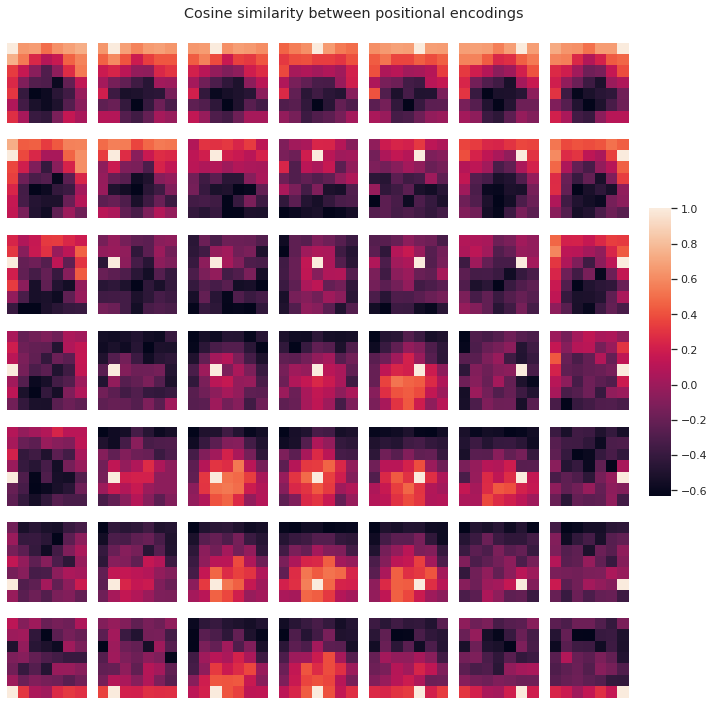

In [7]:
sns.set_theme()

fig, axes = plt.subplots(n_per_side, n_per_side, sharex=True, sharey=True, figsize=(10,10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(n):
    sns.heatmap(similarities[i,:].reshape(7,7), square=True, ax=axes[i//n_per_side,i%n_per_side], cbar= not i, cbar_ax= None if i else cbar_ax)

plt.setp(axes, xticks=[], yticks=[])
plt.suptitle("Cosine similarity between positional encodings")

fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.tight_layout(rect=[0, 0, 0.9, 0.95])